# Similarity Analysis & Sentence embeddings.
To do similarity analysis on all documents we want an embedding for each document. An embedding is a vector representation of the document. I will use sentence's to demonstrate the concepts. 

In [194]:
from sentence_transformers import SentenceTransformer
import numpy as np
# graph the vectors and their cosine similarities
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

### Cosine Similarity.
Sentence embeddings are vectors that represent the meaning of a sentence. The cosine similarity between two vectors calculates the cosine of the angle between them. 
- If the vectors are similar, the cosine similarity will be close to 1. 
- if the vectors are orthogonal(unrelated), the cosine similarity will be 0.
- If the vectors are dissimilar, the cosine similarity will be close to -1.

the cosine similarity is calculated as follows:
$$\text{cos}(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}$$
where $\mathbf{A} \cdot \mathbf{B}$ is the dot product of the vectors and $\|\mathbf{A}\|\|\mathbf{B}\|$ is the product of the magnitudes of the vectors.


In [195]:
def cosine_similarity(a, b):
    """The cosine similarity between two sentence embeddings."""
    return (a@b) / (np.linalg.norm(a) * np.linalg.norm(b))

### Sentence Transformers
I am using the `sentence-transformers` library to generate embeddings for the sentences. The library provides a simple interface to generate embeddings for sentences. The library can be installed using the following command:
```bash
pip install sentence-transformers
```
I will use the all-MiniLM-L6-v2 model to generate embeddings for each document. Info on the model can be found [here](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

In [196]:
# Load the model we want to use. Most Hugging Face models are supported. all-MiniLM-L6-v2 is a small model that works well for demonstration.
model = SentenceTransformer('all-MiniLM-L6-v2')

In [197]:
# The stand-in data pool of plain text documents.
documents = [
    'We have 200 costumers around the world with 1000 products.',
    'We have costumers world wide with products in the thousands.',
    'Our products are known by costumers all over the world.',
    'Our company makes ice cream.',
    'This is a test sentence.',
]
doc_embeddings = model.encode(documents)

In [198]:
doc_embeddings.shape

(5, 384)

Now we create a dataframe of embedded documents to stand in for a vector database.

In [199]:
df = pd.DataFrame(doc_embeddings)
# add 'doc'+str(i) as the index
df.index = ['doc'+str(i) for i in range(len(documents))]
df.shape

(5, 384)

### Similarity Analysis.
Now that we have embeddings for all documents organized, its easy to calculate the similarity between any two documents. The first 3 documents are similar, so the cosine similarity between them will be close to 1. The last document about ice cream is unrelated to the first 3, so the cosine similarity will be close to 0.

The following code calculates the cosine similarity between all documents and stores the results in a dataframe for easy access.

In [200]:
# Calculate the cosine similarity between all pairs of documents
cosine_sim = df.dot(df.T)
cosine_sim

# # take the upper triangle of the matrix
cosine_sim = cosine_sim.where(np.triu(np.ones(cosine_sim.shape), k=1).astype(np.bool))
cosine_sim

,doc0,doc1,doc2,doc3,doc4
doc0,NaN,0.888201,0.722088,0.244670,0.033513
doc1,NaN,NaN,0.869922,0.316562,0.044312
doc2,NaN,NaN,NaN,0.360076,0.037322
doc3,NaN,NaN,NaN,NaN,0.114571
doc4,NaN,NaN,NaN,NaN,NaN


In [201]:
# check if the pandas cosine similarity is the same as what we get from the function
x = cosine_similarity(doc_embeddings[0], doc_embeddings[4])
assert np.allclose(x, cosine_sim.iloc[0, 4])


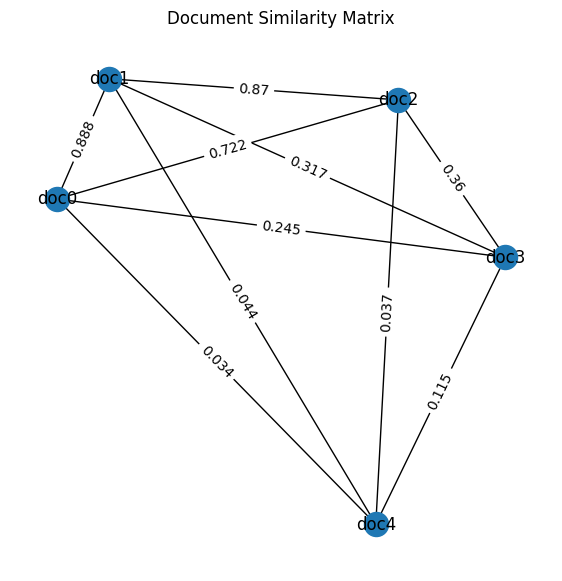

In [202]:
# Create a graph from the cosine similarity matrix
G = nx.from_pandas_adjacency(cosine_sim.fillna(0))

pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
# round the labels to 2 decimal places
labels = {k: round(v, 3) for k, v in labels.items()}
# Draw the graph
plt.figure(figsize=(7, 7))
plt.title('Document Similarity Matrix')
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()